In [ ]:
import pandas as pd
import re
import numpy as np
from nltk.tokenize import TweetTokenizer
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from gensim.models import KeyedVectors
from gensim.downloader import load
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score

In [ ]:
data = pd.read_csv('all_sources_metadata_2020-03-13.csv')

In [ ]:
data.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


##Preprocessing

In [ ]:
# List of column names to drop
columns_to_drop = ['sha', 'source_x',	'doi', 'pmcid',	'pubmed_id',	'license',	'Microsoft Academic Paper ID',	'WHO #Covidence', 'has_full_text']

# Drop the specified columns
data = data.drop(columns=columns_to_drop)

In [ ]:
null_count_title = data['title'].isnull().sum()
null_count_abstract = data['abstract'].isnull().sum()

print(null_count_title, null_count_abstract)

9 2591


In [ ]:
data = data.dropna(subset=['title'])
data = data.dropna(subset=['abstract'])

# Reset the index
data.reset_index(drop=True, inplace=True)

In [ ]:
data.head()

,title,abstract,publish_time,authors,journal
0,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine
1,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med
2,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling
3,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling
4,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine


In [ ]:
data['Title'] = data['title'].str.lower()
data['Abstract'] = data['abstract'].str.lower()

In [ ]:
def clean_text(text):
    # Check if the tweet is a non-null string
    if isinstance(text, str) and not pd.isnull(text):
        # remove URL
        text = re.sub(r"http\S+", "", text)

        # Remove short links (e.g., buff.ly/2WmmiP5)
        text = re.sub(r"\b\w+:\/\/\S+", "", text)

        # Remove usernames
        text = re.sub(r"@[^\s]+[\s]?", '', text)

        # remove special characters
        text = re.sub('[^ a-zA-Z0-9]', '', text)

        # remove Numbers
        text = re.sub('[0-9]', '', text)

        return text
    else:
        # If the tweet is NaN or not a string, return it unchanged
        return text

In [ ]:
data['Title'] = data['Title'].apply(clean_text)
data['Abstract'] = data['Abstract'].apply(clean_text)

In [ ]:
tt = TweetTokenizer()

data['Title'] = data['Title'].astype(str)
data['Title'] = data['Title'].apply(tt.tokenize)

data['Abstract'] = data['Abstract'].astype(str)
data['Abstract'] = data['Abstract'].apply(tt.tokenize)

In [ ]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("english")

# Define a function to remove stop words
def remove_stop_words(word_list):
    return [word for word in word_list if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data['Title'] = data['Title'].apply(remove_stop_words)

data['Abstract'] = data['Abstract'].apply(remove_stop_words)

In [ ]:
# data.drop(data[data['title'].apply(len) == 0].index, inplace=True)
# data.reset_index(drop=True, inplace=True)

# data.drop(data[data['abstract'].apply(len) == 0].index, inplace=True)
# data.reset_index(drop=True, inplace=True)

In [ ]:
ps = PorterStemmer()

def stemming(words):
    stem_words = []
    for w in words:
        w = ps.stem(w)
        stem_words.append(w)

    return stem_words

In [ ]:
# apply steming function
data['Title'] = data['Title'].apply(stemming)

data['Abstract'] = data['Abstract'].apply(stemming)

In [ ]:
data.drop(data[data['Title'].apply(len) == 0].index, inplace=True)
data.reset_index(drop=True, inplace=True)

data.drop(data[data['Abstract'].apply(len) == 0].index, inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
print(len(data))

26907


##Feature Extraction - GloVe

In [ ]:
# Download and load the pretrained GloVe model
glove_model = load('glove-wiki-gigaword-50')

def word_embedding(tweet):
    if isinstance(tweet, list):
        tweet = ' '.join(map(str, tweet))

    return np.mean([glove_model[word] for word in word_tokenize(tweet.lower()) if word in glove_model], axis=0) if tweet else np.zeros(glove_model.vector_size)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Apply the function to create a new 'Embedding' column
data['Embedded title'] = data['Title'].apply(word_embedding)

data['Embedded abstract'] = data['Abstract'].apply(word_embedding)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


##Topic Modeling - LDA

In [ ]:
# Combine the two features into a single text column
data['combined_data'] = data['Title'].apply(lambda x: ' '.join(x)) + ' ' + data['Abstract'].apply(lambda x: ' '.join(x))

# Create a document-term matrix using CountVectorizer (without stop words)
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(data['combined_data'])

# Apply LDA
num_topics = 30
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_result = lda.fit_transform(dtm)

In [ ]:
# Display the topics and their top words
feature_names = vectorizer.get_feature_names_out()
topic_names = [f'Topic {i+1}' for i in range(num_topics)]
top_words_per_topic = []

# Increase the number of top words to 30
num_top_words = 10

for topic_weights in lda.components_:
    top_word_idx = topic_weights.argsort()[:-num_top_words-1:-1]  # Get indices of top 30 words
    top_words = [feature_names[i] for i in top_word_idx]
    top_words_per_topic.append(top_words)

# Create a DataFrame for better visualization
topics_df = pd.DataFrame(top_words_per_topic,
                         columns=[f'Top Word {i+1}' for i in range(num_top_words)],
                         index=topic_names)

print("Topics and their Top Words:")
topics_df

Topics and their Top Words:


,Top Word 1,Top Word 2,Top Word 3,Top Word 4,Top Word 5,Top Word 6,Top Word 7,Top Word 8,Top Word 9,Top Word 10
Topic 1,viru,infect,cell,viral,replic,host,virus,antivir,protein,inhibit
Topic 2,vaccin,immun,develop,review,use,system,respons,diseas,pathogen,new
Topic 3,protein,structur,domain,interact,membran,nsp,function,activ,bind,complex
Topic 4,model,use,data,predict,network,method,transmiss,dynam,estim,epidem
Topic 5,respiratori,infect,rsv,viral,viru,human,tract,children,airway,diseas
Topic 6,temperatur,air,ev,use,aerosol,transmiss,effect,transport,particl,surfac
Topic 7,vector,rat,gene,effect,express,deliveri,sirna,disord,ifn,treatment
Topic 8,patient,respiratori,infect,hospit,case,children,detect,age,studi,year
Topic 9,activ,protein,respons,infect,inhibit,pathway,ifn,stress,signal,autophagi
Topic 10,bat,virus,speci,host,human,evolut,divers,viral,gene,pathogen


In [ ]:
# Add LDA topic probabilities to the original DataFrame
for i in range(num_topics):
    data[f'Topic_{i+1}_Probability'] = lda_result[:, i]

topics_df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame with LDA topic probabilities
# data[['title', 'abstract', 'Topic_1_Probability', 'Topic_2_Probability', 'Topic_3_Probability', 'Topic_4_Probability', 'Topic_5_Probability']]
data.head()

,title,abstract,publish_time,authors,journal,Title,Abstract,Embedded title,Embedded abstract,combined_data,...,Topic_21_Probability,Topic_22_Probability,Topic_23_Probability,Topic_24_Probability,Topic_25_Probability,Topic_26_Probability,Topic_27_Probability,Topic_28_Probability,Topic_29_Probability,Topic_30_Probability
0,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,"[incub, period, epidemiolog, characterist, nov...","[geograph, spread, novel, coronaviru, covid, i...","[0.42462996, -0.28467625, 0.035329267, -0.2650...","[0.28952965, 0.07501082, 0.027063506, -0.25878...",incub period epidemiolog characterist novel co...,...,0.000290,0.000290,0.000290,0.051933,0.000290,0.000290,0.000290,0.321962,0.000290,0.000290
1,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,"[characterist, public, health, respons, corona...","[decemb, case, unidentifi, pneumonia, histori,...","[0.39076898, -0.0027225167, -0.1649415, 0.1293...","[0.4728568, 0.045145813, -0.005547898, -0.0003...",characterist public health respons coronaviru ...,...,0.000251,0.021933,0.000251,0.100933,0.000251,0.000251,0.000251,0.375599,0.052710,0.000251
2,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,"[updat, estim, risk, transmiss, novel, coronav...","[basic, reproduct, number, infecti, agent, ave...","[0.76795995, 0.33046702, -0.3279, -0.63524, -0...","[0.30133936, 0.07935035, 0.14961886, -0.233641...",updat estim risk transmiss novel coronaviru nc...,...,0.000224,0.000224,0.000224,0.000224,0.000224,0.000224,0.000224,0.424824,0.000224,0.000224
3,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,"[realtim, forecast, ncov, epidem, china, febru...","[initi, cluster, sever, pneumonia, case, trigg...","[-0.110995, 0.541855, 0.8358755, 0.31332198, 0...","[0.37046963, 0.003075262, 0.25536847, 0.072885...",realtim forecast ncov epidem china februari th...,...,0.000156,0.000156,0.000156,0.000156,0.000156,0.000156,0.000156,0.624344,0.000156,0.000156
4,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,"[covid, outbreak, diamond, princess, cruis, sh...","[cruis, ship, carri, larg, number, peopl, conf...","[0.44852072, 0.2362625, -0.31230977, 0.0640475...","[0.39290023, -0.0023093107, 0.17302836, -0.042...",covid outbreak diamond princess cruis ship est...,...,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.505698,0.000193,0.000193


##Dimentionality Reduction - PCA

In [ ]:
# Apply PCA to LDA results
num_pca_components = 2
pca = PCA(n_components=num_pca_components)
pca_result = pca.fit_transform(lda_result)

# Display the explained variance ratio for each PCA component
print("Explained Variance Ratio for PCA Components:")
print(pca.explained_variance_ratio_)

# Add PCA components to the original DataFrame
pca_column_names = [f'PCA_{i+1}' for i in range(num_pca_components)]
for i in range(num_pca_components):
    data[pca_column_names[i]] = pca_result[:, i]

# Display the resulting DataFrame with LDA topic probabilities and PCA components
data[['Title', 'Abstract'] + [f'Topic_{i+1}_Probability' for i in range(num_topics)] + pca_column_names]

Explained Variance Ratio for PCA Components:
[0.12454516 0.08380592]


,Title,Abstract,Topic_1_Probability,Topic_2_Probability,Topic_3_Probability,Topic_4_Probability,Topic_5_Probability,Topic_6_Probability,Topic_7_Probability,Topic_8_Probability,...,Topic_23_Probability,Topic_24_Probability,Topic_25_Probability,Topic_26_Probability,Topic_27_Probability,Topic_28_Probability,Topic_29_Probability,Topic_30_Probability,PCA_1,PCA_2
0,"[incub, period, epidemiolog, characterist, nov...","[geograph, spread, novel, coronaviru, covid, i...",0.000290,0.000290,0.023322,0.209246,0.000290,0.000290,0.000290,0.386290,...,0.000290,0.051933,0.000290,0.000290,0.000290,0.321962,0.000290,0.000290,0.299619,-0.069350
1,"[characterist, public, health, respons, corona...","[decemb, case, unidentifi, pneumonia, histori,...",0.000251,0.000251,0.000251,0.000251,0.000251,0.000251,0.000251,0.000251,...,0.000251,0.100933,0.000251,0.000251,0.000251,0.375599,0.052710,0.000251,0.303154,0.053905
2,"[updat, estim, risk, transmiss, novel, coronav...","[basic, reproduct, number, infecti, agent, ave...",0.000224,0.000224,0.000224,0.388324,0.000224,0.000224,0.000224,0.000224,...,0.000224,0.000224,0.000224,0.000224,0.000224,0.424824,0.000224,0.000224,0.380600,0.111029
3,"[realtim, forecast, ncov, epidem, china, febru...","[initi, cluster, sever, pneumonia, case, trigg...",0.000156,0.000156,0.000156,0.294821,0.000156,0.000156,0.000156,0.069587,...,0.000156,0.000156,0.000156,0.000156,0.000156,0.624344,0.000156,0.000156,0.549873,0.130704
4,"[covid, outbreak, diamond, princess, cruis, sh...","[cruis, ship, carri, larg, number, peopl, conf...",0.000193,0.000193,0.000193,0.126125,0.000193,0.063061,0.000193,0.300107,...,0.000193,0.000193,0.000193,0.000193,0.000193,0.505698,0.000193,0.000193,0.451356,-0.005110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26902,"[predict, covid, spread, profil, south, korea,...","[jatspthi, work, appli, datadriven, code, meth...",0.000321,0.000321,0.000321,0.549110,0.000321,0.000321,0.000321,0.145287,...,0.040835,0.000321,0.000321,0.000321,0.000321,0.256435,0.000321,0.000321,0.258206,0.021018
26903,"[determinist, epidem, model, emerg, covid, china]","[jatspcoronaviru, diseas, covid, broke, wuhan,...",0.000498,0.000498,0.000498,0.123568,0.000498,0.000498,0.000498,0.000498,...,0.000498,0.023418,0.000498,0.000498,0.000498,0.650290,0.000498,0.000498,0.537744,0.167508
26904,"[datadriven, discoveri, clinic, rout, sever, d...","[jatspth, outbreak, covid, epidem, caus, world...",0.000629,0.000629,0.000629,0.000629,0.000629,0.000629,0.000629,0.456038,...,0.000629,0.110121,0.000629,0.000629,0.000629,0.268291,0.000629,0.000629,0.249016,-0.142401
26905,"[ascertain, rate, novel, coronaviru, diseas, c...","[jatspw, analyz, epidemiolog, dataset, confirm...",0.000725,0.000725,0.000725,0.102060,0.000725,0.000725,0.000725,0.437839,...,0.000725,0.330451,0.000725,0.000725,0.000725,0.000725,0.000725,0.000725,0.020798,-0.201854


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Silhouette Score')

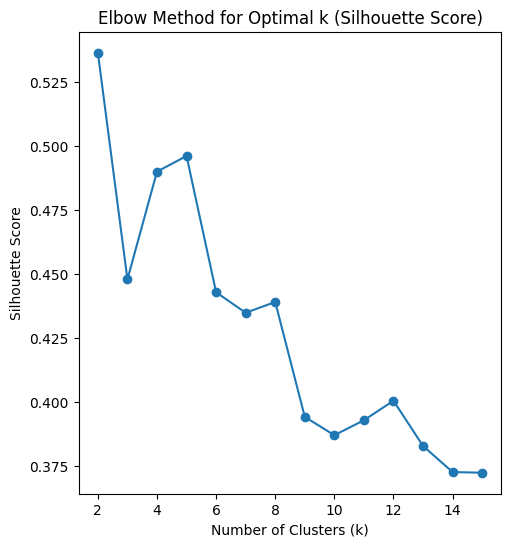

In [ ]:
features = ['PCA_1', 'PCA_2']
X = data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method to find the optimal number of clusters (k)
silhouette_scores = []
max_clusters = min(len(X), 15)  # Limit the number of clusters to the number of samples

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)

    # Calculate silhouette score for each k (if applicable)
    if k < len(X):
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    else:
        silhouette_scores.append(None)

# Plot Elbow Method
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Elbow Method for Optimal k (Silhouette Score)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

##Clustering - KMeans

In [ ]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
data.head()

,title,abstract,publish_time,authors,journal,Title,Abstract,Embedded title,Embedded abstract,combined_data,...,Topic_24_Probability,Topic_25_Probability,Topic_26_Probability,Topic_27_Probability,Topic_28_Probability,Topic_29_Probability,Topic_30_Probability,PCA_1,PCA_2,KMeans_Cluster
0,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,"[incub, period, epidemiolog, characterist, nov...","[geograph, spread, novel, coronaviru, covid, i...","[0.42462996, -0.28467625, 0.035329267, -0.2650...","[0.28952965, 0.07501082, 0.027063506, -0.25878...",incub period epidemiolog characterist novel co...,...,0.051933,0.000290,0.000290,0.000290,0.321962,0.000290,0.000290,0.299619,-0.069350,1
1,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,"[characterist, public, health, respons, corona...","[decemb, case, unidentifi, pneumonia, histori,...","[0.39076898, -0.0027225167, -0.1649415, 0.1293...","[0.4728568, 0.045145813, -0.005547898, -0.0003...",characterist public health respons coronaviru ...,...,0.100933,0.000251,0.000251,0.000251,0.375599,0.052710,0.000251,0.303154,0.053905,1
2,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,"[updat, estim, risk, transmiss, novel, coronav...","[basic, reproduct, number, infecti, agent, ave...","[0.76795995, 0.33046702, -0.3279, -0.63524, -0...","[0.30133936, 0.07935035, 0.14961886, -0.233641...",updat estim risk transmiss novel coronaviru nc...,...,0.000224,0.000224,0.000224,0.000224,0.424824,0.000224,0.000224,0.380600,0.111029,1
3,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,"[realtim, forecast, ncov, epidem, china, febru...","[initi, cluster, sever, pneumonia, case, trigg...","[-0.110995, 0.541855, 0.8358755, 0.31332198, 0...","[0.37046963, 0.003075262, 0.25536847, 0.072885...",realtim forecast ncov epidem china februari th...,...,0.000156,0.000156,0.000156,0.000156,0.624344,0.000156,0.000156,0.549873,0.130704,1
4,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,"[covid, outbreak, diamond, princess, cruis, sh...","[cruis, ship, carri, larg, number, peopl, conf...","[0.44852072, 0.2362625, -0.31230977, 0.0640475...","[0.39290023, -0.0023093107, 0.17302836, -0.042...",covid outbreak diamond princess cruis ship est...,...,0.000193,0.000193,0.000193,0.000193,0.505698,0.000193,0.000193,0.451356,-0.005110,1


In [ ]:
# 'KMeans_Cluster' is the column containing cluster labels
cluster_labels_kmeans = data['KMeans_Cluster']

# Calculate silhouette score
silhouette_avg = silhouette_score(pca_result, cluster_labels_kmeans)

print(f"Silhouette Score for K-means Clusters: {silhouette_avg}")

Silhouette Score for K-means Clusters: 0.5786428885260093


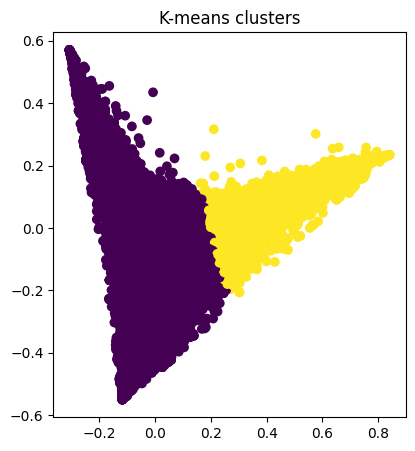

In [ ]:
# PCA visualization
plt.figure(figsize=(10, 5))
plt.subplot(121)
# plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels_kmeans)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels_kmeans)
plt.title("K-means clusters")
plt.show()

In [ ]:
# Create a dictionary to store samples for each cluster
samples_per_cluster = {}

# Number of samples to extract from each cluster
samples_per_cluster_count = 10

# Iterate through each cluster and extract 10 samples
for cluster_label in range(2):  # Assuming 2 clusters
    cluster_samples = data[data['KMeans_Cluster'] == cluster_label].head(samples_per_cluster_count)
    samples_per_cluster[cluster_label] = cluster_samples

# Display the samples from each cluster with full text (title and abstract)
for cluster_label, cluster_samples in samples_per_cluster.items():
    print(f"\nSamples from Cluster {cluster_label}:\n")
    for index, row in cluster_samples.iterrows():
        print(f"Title: {row['title']}")
        #print(f"Abstract: {row['abstract']}\n")


Samples from Cluster 0:

Title: Distinct Roles for Sialoside and Protein Receptors in Coronavirus Infection
Title: Genome Detective Coronavirus Typing Tool for rapid identification and characterization of novel coronavirus genomes
Title: Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR
Title: Nonstructural proteins NS7b and NS8 are likely to be phylogenetically associated with evolution of 2019-nCoV
Title: HRCT Imaging Features in Representative Imported Cases of 2019 Novel Coronavirus Pneumonia
Title: Comprehensive Genomic Characterization Analysis of lncRNAs in Cells With Porcine Delta Coronavirus Infection
Title: Systematic Comparison of Two Animal-to-Human Transmitted Human Coronaviruses: SARS-CoV-2 and SARS-CoV
Title: A new coronavirus associated with human respiratory disease in China
Title: Discovery and development of s

##Clustering - Agglomerative

In [ ]:
# Apply Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=2)
data['Agglomerative_Cluster'] = agglomerative.fit_predict(X_scaled)

In [ ]:
data.head()

,title,abstract,publish_time,authors,journal,Title,Abstract,Embedded title,Embedded abstract,combined_data,...,Topic_25_Probability,Topic_26_Probability,Topic_27_Probability,Topic_28_Probability,Topic_29_Probability,Topic_30_Probability,PCA_1,PCA_2,KMeans_Cluster,Agglomerative_Cluster
0,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,"[incub, period, epidemiolog, characterist, nov...","[geograph, spread, novel, coronaviru, covid, i...","[0.42462996, -0.28467625, 0.035329267, -0.2650...","[0.28952965, 0.07501082, 0.027063506, -0.25878...",incub period epidemiolog characterist novel co...,...,0.000290,0.000290,0.000290,0.321962,0.000290,0.000290,0.299619,-0.069350,1,0
1,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,"[characterist, public, health, respons, corona...","[decemb, case, unidentifi, pneumonia, histori,...","[0.39076898, -0.0027225167, -0.1649415, 0.1293...","[0.4728568, 0.045145813, -0.005547898, -0.0003...",characterist public health respons coronaviru ...,...,0.000251,0.000251,0.000251,0.375599,0.052710,0.000251,0.303154,0.053905,1,0
2,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,"[updat, estim, risk, transmiss, novel, coronav...","[basic, reproduct, number, infecti, agent, ave...","[0.76795995, 0.33046702, -0.3279, -0.63524, -0...","[0.30133936, 0.07935035, 0.14961886, -0.233641...",updat estim risk transmiss novel coronaviru nc...,...,0.000224,0.000224,0.000224,0.424824,0.000224,0.000224,0.380600,0.111029,1,1
3,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,"[realtim, forecast, ncov, epidem, china, febru...","[initi, cluster, sever, pneumonia, case, trigg...","[-0.110995, 0.541855, 0.8358755, 0.31332198, 0...","[0.37046963, 0.003075262, 0.25536847, 0.072885...",realtim forecast ncov epidem china februari th...,...,0.000156,0.000156,0.000156,0.624344,0.000156,0.000156,0.549873,0.130704,1,1
4,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,"[covid, outbreak, diamond, princess, cruis, sh...","[cruis, ship, carri, larg, number, peopl, conf...","[0.44852072, 0.2362625, -0.31230977, 0.0640475...","[0.39290023, -0.0023093107, 0.17302836, -0.042...",covid outbreak diamond princess cruis ship est...,...,0.000193,0.000193,0.000193,0.505698,0.000193,0.000193,0.451356,-0.005110,1,1


In [ ]:
# 'Agglomerative_Cluster' is the column containing cluster labels
cluster_labels_agglomerative = data['Agglomerative_Cluster']

# Calculate silhouette score
silhouette_avg = silhouette_score(pca_result, cluster_labels_agglomerative)

print(f"Silhouette Score for Agglomerative Clusters: {silhouette_avg}")

Silhouette Score for Agglomerative Clusters: 0.5987445357708358


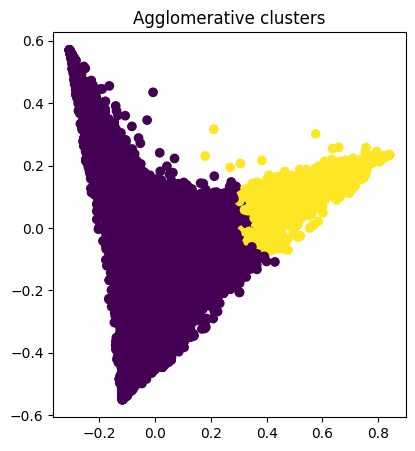

In [ ]:
# Agglomerative visualization
plt.figure(figsize=(10, 5))
plt.subplot(121)
# plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels_agglomerative)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels_agglomerative)
plt.title("Agglomerative clusters")
plt.show()

In [ ]:
# Create a dictionary to store samples for each cluster
samples_per_cluster = {}

# Number of samples to extract from each cluster
samples_per_cluster_count = 10

# Iterate through each cluster and extract 10 samples
for cluster_label in range(2):  # Assuming 2 clusters
    cluster_samples = data[data['Agglomerative_Cluster'] == cluster_label].head(samples_per_cluster_count)
    samples_per_cluster[cluster_label] = cluster_samples

# Display the samples from each cluster with full text (title and abstract)
for cluster_label, cluster_samples in samples_per_cluster.items():
    print(f"\nSamples from Cluster {cluster_label}:\n")
    for index, row in cluster_samples.iterrows():
        print(f"Title: {row['title']}")
        #print(f"Abstract: {row['abstract']}\n")


Samples from Cluster 0:

Title: Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data
Title: Characteristics of and Public Health Responses to the Coronavirus Disease 2019 Outbreak in China
Title: Distinct Roles for Sialoside and Protein Receptors in Coronavirus Infection
Title: Effectiveness of airport screening at detecting travellers infected with novel coronavirus (2019-nCoV)
Title: Genome Detective Coronavirus Typing Tool for rapid identification and characterization of novel coronavirus genomes
Title: Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR
Title: Emergence of Novel Coronavirus 2019-nCoV: Need for Rapid Vaccine and Biologics Development
Title: Nonstructural proteins NS7b and NS8 are likely to b